In [8]:
    import hopsworks
    import pandas as pd
    from sklearn.neighbors import KNeighborsRegressor
    from sklearn.metrics import accuracy_score
    from sklearn.metrics import confusion_matrix
    from sklearn.metrics import mean_squared_error
    import seaborn as sns
    from matplotlib import pyplot
    from hsml.schema import Schema
    from hsml.model_schema import ModelSchema
    import joblib
    import os

In [9]:
# You have to set the environment variable 'HOPSWORKS_API_KEY' for login to succeed
project = hopsworks.login()
fs = project.get_feature_store()

Connection closed.
Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/195733
Connected. Call `.close()` to terminate connection gracefully.


In [10]:
wine_fg = fs.get_feature_group(name="wine", version=1)
query = wine_fg.select_all()
feature_view = fs.get_or_create_feature_view(name="wine",
                                  version=1,
                                  description="Read from Wine quality dataset",
                                  labels=["quality"],
                                  query=query)

In [11]:
X_train, X_test, y_train, y_test = feature_view.train_test_split(0.2)

model = KNeighborsRegressor()
model.fit(X_train, y_train.values.ravel())

Finished: Reading data from Hopsworks, using ArrowFlight (1.60s) 


KNeighborsRegressor()

In [12]:
# Evaluate model performance using the features from the test set (X_test)
y_pred = model.predict(X_test)

# Compare predictions (y_pred) with the labels in the test set (y_test)
cols = list(range(0, 11))
results = confusion_matrix(y_test, list(map(round, y_pred)), labels=cols)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

Mean Squared Error: 0.7443166823751178


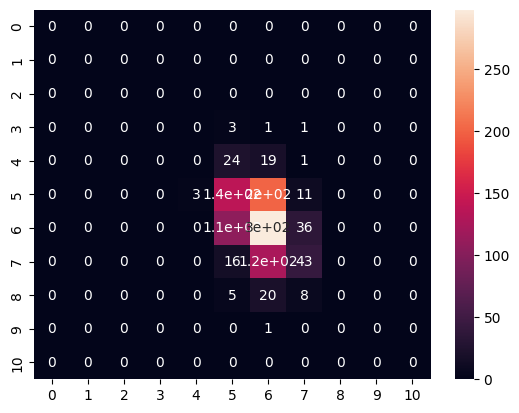

In [13]:
# Create the confusion matrix as a figure, we will later store it as a PNG image file
df_cm = pd.DataFrame(results, cols, cols)
cm = sns.heatmap(df_cm, annot=True)
fig = cm.get_figure()

In [14]:
mr = project.get_model_registry()

model_dir="wine_model"
if os.path.isdir(model_dir) == False:
    os.mkdir(model_dir)

# Save both our model and the confusion matrix to 'model_dir', whose contents will be uploaded to the model registry
joblib.dump(model, model_dir + "/wine_model.pkl")
fig.savefig(model_dir + "/confusion_matrix.png")    

# Specify the schema of the model's input/output using the features (X_train) and labels (y_train)
input_schema = Schema(X_train)
output_schema = Schema(y_train)
model_schema = ModelSchema(input_schema, output_schema)

# Create an entry in the model registry that includes the model's name, desc, metrics
wine_model = mr.python.create_model(
    name="wine_model", 
    metrics={"mse" : mse},
    model_schema=model_schema,
    description="Wine Quality Predictor"
)

# Upload the model to the model registry, including all files in 'model_dir'
wine_model.save(model_dir)

Connected. Call `.close()` to terminate connection gracefully.


Model export complete: 100%|██████████| 6/6 [00:15<00:00,  2.52s/it]                   

Model created, explore it at https://c.app.hopsworks.ai:443/p/195733/models/wine_model/2


Model(name: 'wine_model', version: 2)